# Creating Model (Train & Validation)

## Module Installation & Imports

In [1]:
# File handling and OS
import os
import gdown
import zipfile

# Data processing
import pandas as pd
import numpy as np
import idx2numpy

# Image processing
import cv2
from scipy.ndimage import gaussian_filter, sobel, prewitt, median_filter
from skimage.feature import canny

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
from xgboost import XGBClassifier

# Deep Learning
import tensorflow as tf
from tensorflow.keras import models, layers  # type: ignore
from tensorflow.keras.utils import to_categorical # type: ignore

# Miscellaneous
import warnings
import time
import random

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

## File/Data Loading

In [2]:
# URL of the file on Google Drive
file_url = "https://drive.google.com/uc?id=10CensBIDjtk_kaYBHTtlSHOc3Npn1cJ-"

# Output filename
output_file = "mnist_dataset.zip"

# Download the file
print("Downloading dataset...")
try:
    gdown.download(file_url, output_file, quiet=False)
    print(f"File downloaded: {output_file}")
except Exception as e:
    print(f"Failed to download the file: {e}")
    exit()

# Check if the file exists and unzip it
if os.path.exists(output_file):
    if output_file.endswith(".zip"):
        print("Extracting ZIP file...")
        try:
            with zipfile.ZipFile(output_file, 'r') as zip_ref:
                zip_ref.extractall("mnist_data")
            print("Dataset extracted to 'mnist_data' folder.")
        except zipfile.BadZipFile:
            print("Error: The file is not a valid ZIP archive.")
    else:
        print(f"The file {output_file} is not a ZIP file.")
else:
    print(f"The file {output_file} does not exist after download.")

Downloading...
From: https://drive.google.com/uc?id=10CensBIDjtk_kaYBHTtlSHOc3Npn1cJ-
To: d:\Fore\DLM CNN\mnist_dataset.zip
100%|██████████| 11.6M/11.6M [00:01<00:00, 7.02MB/s]


File downloaded: mnist_dataset.zip
Extracting ZIP file...
Dataset extracted to 'mnist_data' folder.


In [3]:
# Standardized File Paths
base_path = r'mnist_data'  # Base directory for all MNIST files
train_images_path = f"{base_path}/train-images-idx3-ubyte/train-images-idx3-ubyte"
train_labels_path = f"{base_path}/train-labels-idx1-ubyte/train-labels-idx1-ubyte"
test_images_path = f"{base_path}/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte"
test_labels_path = f"{base_path}/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte"

In [4]:
# Load data
train_images = idx2numpy.convert_from_file(train_images_path)
train_labels = idx2numpy.convert_from_file(train_labels_path)
test_images = idx2numpy.convert_from_file(test_images_path)
test_labels = idx2numpy.convert_from_file(test_labels_path)

In [5]:
# Define augmentation parameters
rotation_angles = [-30, -20, -10, -5, 0, 5, 10, 20, 30]  # Expanded rotation angles
zoom_factors = [0.75, 0.85, 0.9, 1,  1.1, 1.2, 1.3]  # Expanded zoom factors

# Original image size (for MNIST it's 28x28)
img_size = train_images.shape[1:]

# Function to rotate image
def rotate_image(image, angle):
    h, w = image.shape
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REPLICATE)
    return rotated

# Function to zoom image and ensure it returns the correct size
def zoom_image(image, factor):
    h, w = image.shape
    zoomed = cv2.resize(image, None, fx=factor, fy=factor, interpolation=cv2.INTER_LINEAR)

    # If zoomed in, crop center; if zoomed out, pad
    if factor > 1.0:
        start_x = (zoomed.shape[1] - w) // 2
        start_y = (zoomed.shape[0] - h) // 2
        zoomed = zoomed[start_y:start_y + h, start_x:start_x + w]
    else:
        pad_x = (w - zoomed.shape[1]) // 2
        pad_y = (h - zoomed.shape[0]) // 2
        zoomed = cv2.copyMakeBorder(zoomed, pad_y, pad_y, pad_x, pad_x, cv2.BORDER_REPLICATE)

    # Resize back to the original shape (in case of rounding issues)
    zoomed = cv2.resize(zoomed, (w, h), interpolation=cv2.INTER_LINEAR)

    return zoomed

# Augment dataset
augmented_images = []
augmented_labels = []

# Select a random subset of images to augment (to triple data size)
total_images = len(train_images)
num_to_augment = total_images  # To ensure dataset size is tripled
selected_indices = random.sample(range(total_images), num_to_augment)

for idx in range(total_images):
    img = train_images[idx]
    label = train_labels[idx]
    augmented_images.append(img)
    augmented_labels.append(label)

    if idx in selected_indices:
        # Randomly choose a rotation and zoom factor
        angle = random.choice(rotation_angles)
        factor = random.choice(zoom_factors)

        rotated_img = rotate_image(img, angle)
        rotated_img = cv2.resize(rotated_img, img_size, interpolation=cv2.INTER_LINEAR)
        augmented_images.append(rotated_img)
        augmented_labels.append(label)

        rotated_zoomed = zoom_image(rotated_img, factor)
        rotated_zoomed = cv2.resize(rotated_zoomed, img_size, interpolation=cv2.INTER_LINEAR)
        augmented_images.append(rotated_zoomed)
        augmented_labels.append(label)

# Convert lists to numpy arrays and update train_images & train_labels
train_images = np.array(augmented_images, dtype=np.uint8).reshape(-1, *img_size)
train_labels = np.array(augmented_labels, dtype=np.uint8)

print(f"Augmentation complete! New dataset size: {len(train_images)} images.")

Augmentation complete! New dataset size: 180000 images.


In [6]:
# Ensure there are at least 60,000 images
num_samples = min(60000, len(train_images))

# Generate random indices
random_indices = np.random.choice(len(train_images), num_samples, replace=False)

# Subset images and labels using the same random indices
train_images_subset = train_images[random_indices]
train_labels_subset = train_labels[random_indices]

# Verify shapes
print(train_images_subset.shape, train_labels_subset.shape)

# Ensure labels are correctly paired
assert train_images_subset.shape[0] == train_labels_subset.shape[0]


(60000, 28, 28) (60000,)


## Data information

In [7]:
# Check the shapes
print("Train images shape:", train_images.shape)  # (60000, 28, 28)
print("Train labels shape:", train_labels.shape)  # (60000,)
print("Test images shape:", test_images.shape)    # (10000, 28, 28)
print("Test labels shape:", test_labels.shape)    # (10000,)

Train images shape: (180000, 28, 28)
Train labels shape: (180000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


In [8]:
# Flatten the images for DataFrame compatibility
train_images_flat = train_images.reshape(train_images.shape[0], -1)  # (60000, 784)
test_images_flat = test_images.reshape(test_images.shape[0], -1)    # (10000, 784)

# Convert to DataFrames
train_images_df = pd.DataFrame(train_images_flat)
train_labels_df = pd.DataFrame(train_labels, columns=["Label"])
test_images_df = pd.DataFrame(test_images_flat)
test_labels_df = pd.DataFrame(test_labels, columns=["Label"])

In [9]:
# Display the head of each DataFrame
pd.set_option('display.max_columns', None)  # Show all columns
print("Train Images (head):")
train_images_df.head()

Train Images (head):


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,18,18,18,126,136,175,26,166,255,247,127,0,0,0,0,0,0,0,0,0,0,0,0,30,36,94,154,170,253,253,253,253,253,225,172,253,242,195,64,0,0,0,0,0,0,0,0,0,0,0,49,238,253,253,253,253,253,253,253,253,251,93,82,82,56,39,0,0,0,0,0,0,0,0,0,0,0,0,18,219,253,253,253,253,253,198,182,247,241,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,80,156,107,253,253,205,11,0,43,154,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,1,154,253,90,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,139,253,190,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,190,253,70,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35,241,225,160,108,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,81,240,253,253,119,25,0,0,

In [10]:
print("\nTrain Labels (head):")
train_labels_df.head()


Train Labels (head):


,Label
0,5
1,5
2,5
3,0
4,0


In [11]:
print("\nTest Images (head):")
test_images_df.head()


Test Images (head):


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707,708,709,710,711,712,713,714,715,716,717,718,719,720,721,722,723,724,725,726,727,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,84,185,159,151,60,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,222,254,254,254,254,241,198,198,198,198,198,198,198,198,170,52,0,0,0,0,0,0,0,0,0,0,0,0,67,114,72,114,163,227,254,225,254,254,254,250,229,254,254,140,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,17,66,14,67,67,67,59,21,236,254,106,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,83,253,209,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22,233,255,83,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,129,254,238,44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,59,249,254,62,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [12]:
print("\nTest Labels (head):")
test_labels_df.head()


Test Labels (head):


,Label
0,7
1,2
2,1
3,0
4,4


## Preprocessing

In [13]:
def apply_sobel_edge_detection(images):
    """
    Apply Sobel edge detection to a set of images.
    """
    images = images.astype(np.float32)
    dx = sobel(images, axis=0)
    dy = sobel(images, axis=1)
    edges = np.hypot(dx, dy)
    return edges / np.max(edges)

def apply_prewitt_edge_detection(images):
    """
    Apply Prewitt edge detection to a set of images.
    """
    images = images.astype(np.float32)
    dx = prewitt(images, axis=0)
    dy = prewitt(images, axis=1)
    edges = np.hypot(dx, dy)
    return edges / np.max(edges)

def apply_canny_edge_detection(images, sigma=1.0):
    """
    Apply Canny edge detection to a set of images.
    """
    edges = np.array([canny(image, sigma=sigma) for image in images])
    return edges.astype(np.float32)

def apply_gaussian_smoothing(images, sigma=1.0):
    """
    Apply Gaussian smoothing to a set of images.
    """
    images = images.astype(np.float32)
    return gaussian_filter(images, sigma=sigma)

def apply_median_smoothing(images, size=3):
    """
    Apply Median filtering for smoothing.
    """
    return median_filter(images, size=size)

def apply_thresholding(images, min_threshold, max_threshold, step):
    """
    Apply thresholding to images based on given range and step.
    """
    thresholds = np.arange(min_threshold, max_threshold + 1, step)
    n_thresholds = len(thresholds)
    split_size = len(images) // n_thresholds
    thresholded_images = []

    for i, threshold in enumerate(thresholds):
        start_index = i * split_size
        end_index = (i + 1) * split_size if i < n_thresholds - 1 else len(images)
        thresholded_slice = np.where(images[start_index:end_index] > threshold, 1, 0)
        thresholded_images.append(thresholded_slice)

    return np.vstack(thresholded_images)

def preprocess_threshold(images, min_threshold=100, max_threshold=200, step=10, sigma=1.0, methods=['sobel']):
    """
    Preprocess images by applying a sequence of edge detection and smoothing methods,
    followed by binary thresholding and final Canny edge detection.
    """
    images = images.astype(np.float32)
    
    for method in methods:
        if method == 'sobel':
            images = apply_sobel_edge_detection(images)
        elif method == 'prewitt':
            images = apply_prewitt_edge_detection(images)
        elif method == 'gaussian':
            images = apply_gaussian_smoothing(images, sigma=sigma)
        elif method == 'median':
            images = apply_median_smoothing(images)
        else:
            raise ValueError(f"Invalid processing method: {method}")
    
    images = apply_thresholding(images, min_threshold, max_threshold, step)
    return images

# Example usage
sigma_value = 0.3
min_threshold = 50
max_threshold = 200
step = 10
methods=['gaussian']
train_images_normalized = preprocess_threshold(train_images, min_threshold=min_threshold, max_threshold=max_threshold, step=step, sigma=sigma_value, methods=methods)
test_images_normalized = preprocess_threshold(test_images, min_threshold=min_threshold, max_threshold=max_threshold, step=step, sigma=sigma_value, methods=methods)

In [14]:
# add gaussian noise
def add_gaussian_noise(images, noise_ratio=0.1):
    """
    Add random 0s and 1s to a fraction of pixels in the images.

    Parameters:
        images (numpy.ndarray): Input images.
        noise_ratio (float): Fraction of pixels to be affected by noise (default is 10%).

    Returns:
        numpy.ndarray: Noisy images with random binary values at specified ratio.
    """
    noisy_images = images.copy()
    num_pixels = images.size
    num_noisy_pixels = int(num_pixels * noise_ratio)
    indices = np.random.choice(num_pixels, num_noisy_pixels, replace=False)
    noisy_images.flat[indices] = np.random.choice([0, 1], size=num_noisy_pixels)
    return noisy_images

# Add noise to the processed images with 10% randomness
train_images_normalized = add_gaussian_noise(train_images_normalized, noise_ratio=0)
test_images_normalized = add_gaussian_noise(test_images_normalized, noise_ratio=0)

## Visualization

Visualizing train_images_normalized:


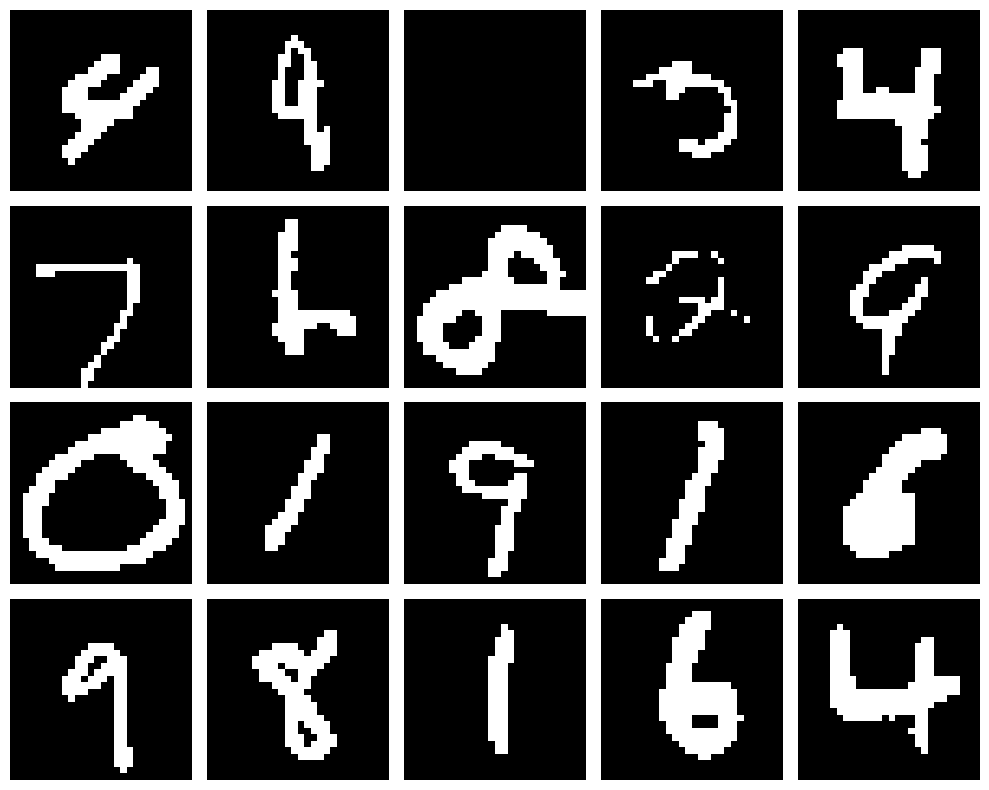

In [15]:
# Function to display normalized images
def display_normalized_images(images, rows=3, cols=3):
    """
    Display a grid of normalized images.

    Parameters:
        images (numpy.ndarray): Array of flattened normalized images.
        rows (int): Number of rows in the grid.
        cols (int): Number of columns in the grid.
    """
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten()

    for i in range(rows * cols):
        if i < len(images):
            # Reshape flattened image back to 28x28
            img = images[i].reshape(28, 28)
            axes[i].imshow(img, cmap='gray')
            axes[i].axis('off')
        else:
            # Turn off unused subplots
            axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage for train_images_normalized (ensure train_images_normalized is defined)
if 'train_images_normalized' in globals():
    rows = 4
    cols = 5
    num_samples = rows * cols  # Number of images to pick randomly
    random_indices = np.random.choice(train_images_normalized.shape[0], num_samples, replace=False)
    print("Visualizing train_images_normalized:")
    display_normalized_images(train_images_normalized[random_indices], rows=rows, cols=cols)
else:
    print("train_images_normalized is not defined.")





## Machine Learning 

In [16]:
# Prepare Data
X_train = train_images_normalized.reshape(train_images_normalized.shape[0], -1)  # Flatten for models
X_test = test_images_normalized.reshape(test_images_normalized.shape[0], -1)
y_train = train_labels
y_test = test_labels

In [17]:
# Initialize metrics storage
results = []
time_list = []

# Helper function to calculate and store metrics

def evaluate_model(model_name, y_true, y_pred, training_time, prediction_time):
    """
    Evaluate the model and store the metrics in the results list.
    
    Parameters:
        model_name (str): Name of the model.
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        training_time (float): Time taken to train the model (in seconds).
        prediction_time (float): Time taken to make predictions (in seconds).
    """
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='weighted')
    rec = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    # Calculate Hit Rate and Miss Rate
    cm = confusion_matrix(y_true, y_pred)
    tp = np.diag(cm)  # True Positives for each class
    fn = cm.sum(axis=1) - tp  # False Negatives for each class
    hit_rate = tp.sum() / (tp.sum() + fn.sum())
    miss_rate = 1 - hit_rate

    results.append({
        'Model': model_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        # 'Hit Rate': hit_rate,
        # 'Miss Rate': miss_rate,
    })
    
    time_list.append({
        'Model': model_name,
        'Training Time': training_time,
        'Prediction Time': prediction_time
    })



# Helper function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

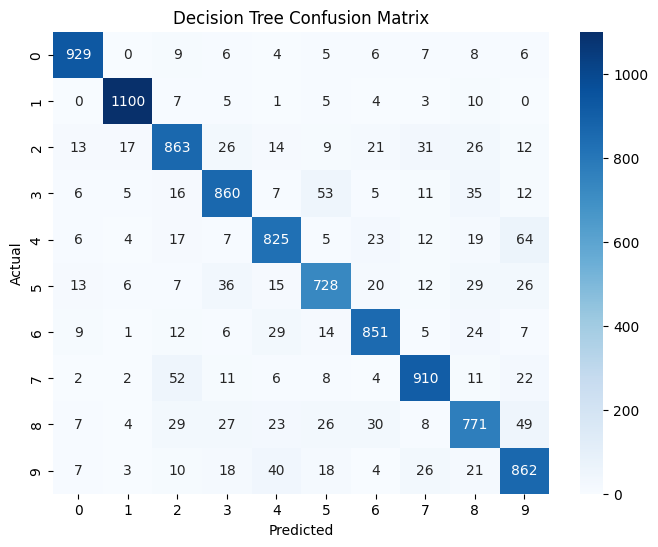

In [18]:
# 1. Decision Tree with Time Measurement
dt = DecisionTreeClassifier()

# Measure the time taken to train the model
start_time = time.time()
dt.fit(X_train, y_train)
training_time = time.time() - start_time  # Time in seconds

# Measure the time taken to make predictions
start_time = time.time()
y_pred_dt = dt.predict(X_test)
prediction_time = time.time() - start_time  # Time in seconds

# Evaluate the model with timing information
evaluate_model("Decision Tree", y_test, y_pred_dt, training_time, prediction_time)

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred_dt, "Decision Tree Confusion Matrix")

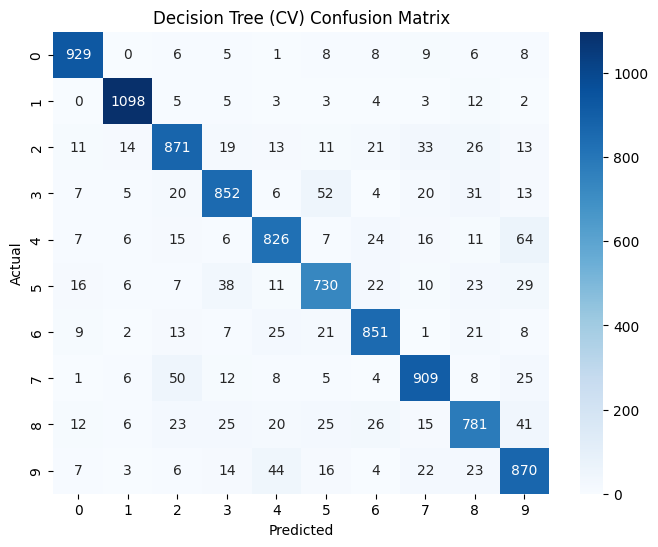

In [19]:
# 2. Decision Tree with Cross-Validation
dt_cv = DecisionTreeClassifier()

# Measure the time taken for cross-validation and training
start_time = time.time()
scores = cross_val_score(dt_cv, X_train, y_train, cv=2, scoring='accuracy')  # Cross-validation
dt_cv.fit(X_train, y_train)  # Train the model
training_time = time.time() - start_time  # Total time for cross-validation and training

# Measure the time taken to make predictions
start_time = time.time()
y_pred_dt_cv = dt_cv.predict(X_test)
prediction_time = time.time() - start_time

# Evaluate the model with timing information
evaluate_model("Decision Tree (CV)", y_test, y_pred_dt_cv, training_time, prediction_time)

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred_dt_cv, "Decision Tree (CV) Confusion Matrix")

# Store cross-validation accuracy
cv_accuracy = np.mean(scores)

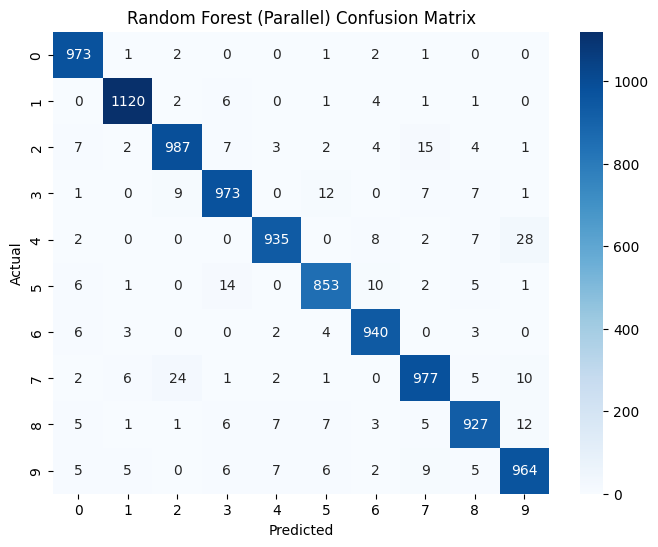

In [20]:
# 3. Random Forest with Parallel Processing
rf = RandomForestClassifier(
    n_estimators=100,   # Number of trees in the forest
    max_depth=20,     # Maximum depth of each tree (None allows trees to expand fully)
    n_jobs=20           # Use up to 16 CPU threads for parallel computation
)

# Measure the time taken to train the model
start_time = time.time()
rf.fit(X_train, y_train)
training_time = time.time() - start_time  # Time in seconds

# Measure the time taken to make predictions
start_time = time.time()
y_pred_rf = rf.predict(X_test)
prediction_time = time.time() - start_time  # Time in seconds

# Evaluate the model with timing information
evaluate_model("Random Forest", y_test, y_pred_rf, training_time, prediction_time)

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest (Parallel) Confusion Matrix")

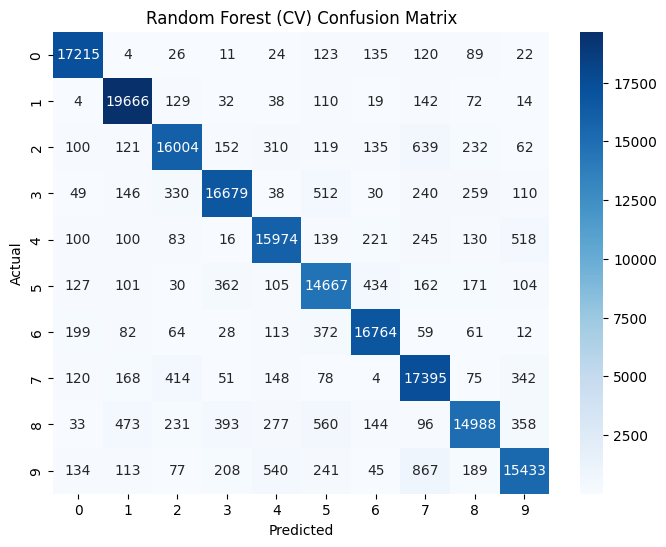

In [21]:
# 4. Random Forest with Cross-Validation
rf_cv = RandomForestClassifier(
    n_estimators=100,  # Number of trees in the forest
    max_depth=20,    # Maximum depth of each tree
    n_jobs=16          # Use up to 16 CPU threads
)

# Measure the time taken to generate cross-validated predictions
start_time = time.time()
y_pred_cv = cross_val_predict(rf_cv, X_train, y_train, cv=3)
training_time = time.time() - start_time  # Time in seconds

# Measure the time taken for predictions on a test set (optional, if separate predictions are needed)
start_time = time.time()
rf_cv.fit(X_train, y_train)  # Train the model to make predictions
y_pred_test = rf_cv.predict(X_test)
prediction_time = time.time() - start_time

# Evaluate the model with timing information
evaluate_model("Random Forest (CV)", y_train, y_pred_cv, training_time, prediction_time)

# Plot confusion matrix for cross-validation predictions
plot_confusion_matrix(y_train, y_pred_cv, "Random Forest (CV) Confusion Matrix")

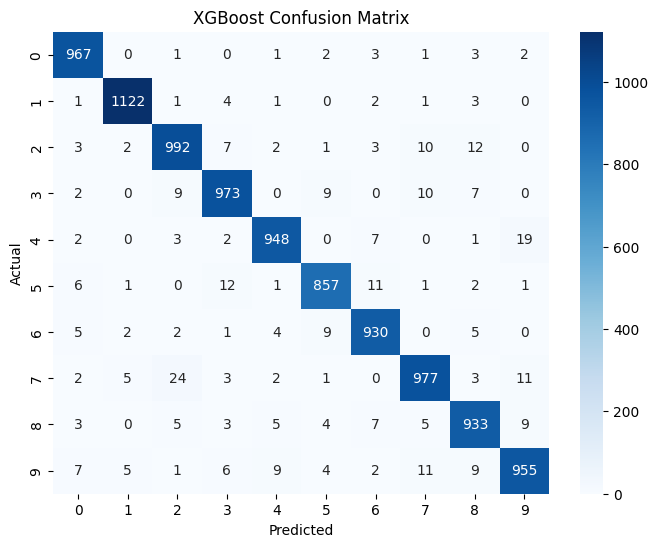

In [22]:
# Suppress all warnings
warnings.filterwarnings("ignore")

# 5. XGBoost
xgb = XGBClassifier(
    eval_metric='mlogloss',  # Multi-class log loss for evaluation
    tree_method='hist',      # Histogram-based split finding for efficiency
    device='cuda',           # Use GPU (or CPU if 'cuda' is unavailable)
    n_jobs=20,               # Use up to 20 CPU threads for preprocessing
    max_depth=20,             # Maximum depth of trees
    learning_rate=0.3,       # Learning rate
    subsample=0.25,
    n_estimators=20         # Number of boosting rounds
)

# Measure the time taken to train the model
start_time = time.time()
xgb.fit(X_train, y_train)
training_time = time.time() - start_time  # Time in seconds

# Measure the time taken to make predictions
start_time = time.time()
y_pred_xgb = xgb.predict(X_test)
prediction_time = time.time() - start_time  # Time in seconds

# Evaluate the model with timing information
evaluate_model("XGBoost", y_test, y_pred_xgb, training_time, prediction_time)

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred_xgb, "XGBoost Confusion Matrix")

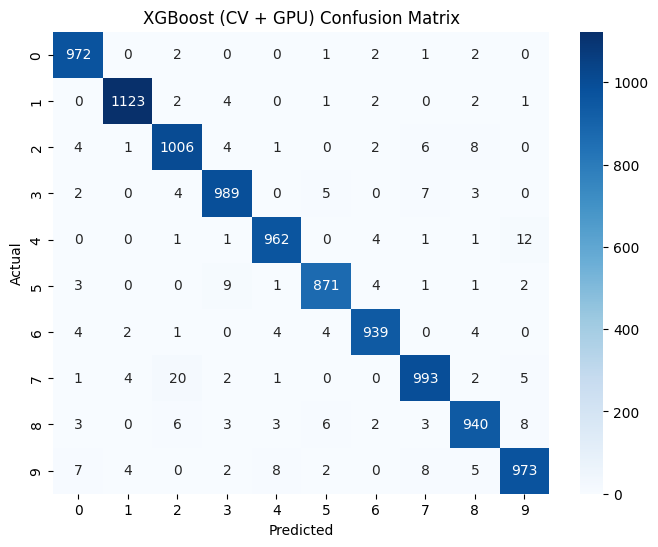

In [23]:
# 6. XGBoost with Cross-Validation (GPU + Parallel Processing)
xgb_cv = XGBClassifier(
    eval_metric='mlogloss',          # Multi-class log loss
    max_depth=20,                   # Maximum depth of each tree
    learning_rate=0.3,               # Learning rate (eta)
    n_estimators=100,                # Number of boosting rounds
    tree_method="hist",              # Enable GPU for tree construction
    device="cuda",                   # Use GPU
    subsample=0.5,
    n_jobs=20                        # Use up to 20 CPU threads
)

# Measure the time taken for cross-validation predictions
start_time = time.time()
y_pred_xgb_cv = cross_val_predict(xgb_cv, X_train, y_train, cv=3, n_jobs=20)
training_time = time.time() - start_time  # Time in seconds

# Measure the time taken for predictions on the test set
start_time = time.time()
xgb_cv.fit(X_train, y_train)  # Train the model
y_pred_test = xgb_cv.predict(X_test)
prediction_time = time.time() - start_time

# Evaluate the model with timing information
evaluate_model("XGBoost (CV)", y_test, y_pred_test, training_time, prediction_time)

# Plot confusion matrix for the test set
plot_confusion_matrix(y_test, y_pred_test, "XGBoost (CV + GPU) Confusion Matrix")

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


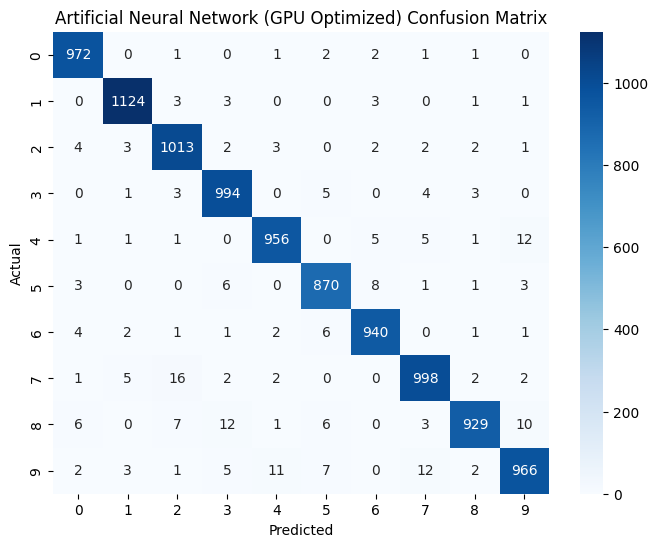

In [24]:
# 7. Artificial Neural Network with GPU and Optimized Training

# Encode labels into one-hot format
y_train_encoded = to_categorical(y_train, num_classes=10)
y_test_encoded = to_categorical(y_test, num_classes=10)

nn = models.Sequential([
    layers.Input(shape=(784,)),    
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Measure training time
start_time = time.time()

with tf.device('/GPU:0'):
# Compile the model
    nn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['mse'])
    nn.fit(X_train, y_train_encoded, epochs=20, batch_size=1024, verbose=0)  # Train the model
training_time = time.time() - start_time  # Training time in seconds

# Measure prediction time
start_time = time.time()
y_pred_nn = np.argmax(nn.predict(X_test), axis=1)
prediction_time = time.time() - start_time  # Prediction time in seconds

# Evaluate the model with timing information
evaluate_model("ANN", y_test, y_pred_nn, training_time, prediction_time)

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred_nn, "Artificial Neural Network (GPU Optimized) Confusion Matrix")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


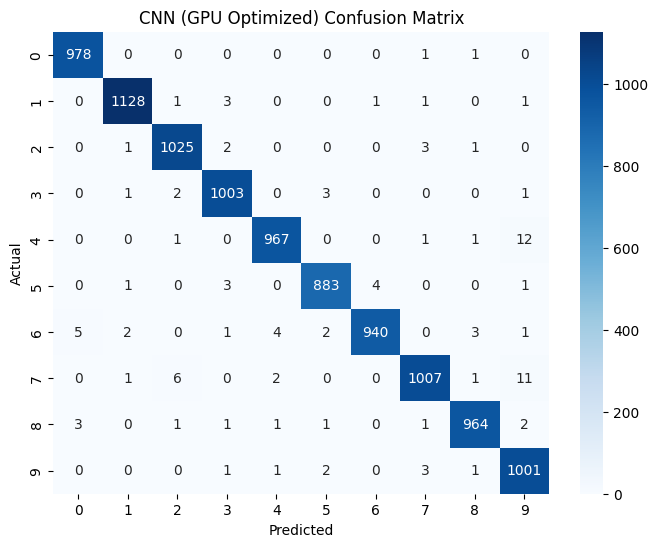

In [25]:
# 8. Convolutional Neural Network with GPU and Optimized Training

# Encode labels into one-hot format
y_train_encoded = to_categorical(y_train, num_classes=10)
y_test_encoded = to_categorical(y_test, num_classes=10)

cnn = models.Sequential([
    layers.Input(shape=(28, 28, 1)),  # Reshape input to 28x28 for CNN
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Measure training time
start_time = time.time()

with tf.device('/GPU:0'):
    # Compile the model
    cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    cnn.fit(X_train.reshape(-1, 28, 28, 1), y_train_encoded, epochs=25, batch_size=1024, verbose=0)  # Train the model
training_time = time.time() - start_time  # Training time in seconds

# Measure prediction time
start_time = time.time()
y_pred_cnn = np.argmax(cnn.predict(X_test.reshape(-1, 28, 28, 1)), axis=1)
prediction_time = time.time() - start_time  # Prediction time in seconds

# Evaluate the model with timing information
evaluate_model("CNN", y_test, y_pred_cnn, training_time, prediction_time)

# Plot confusion matrix
plot_confusion_matrix(y_test, y_pred_cnn, "CNN (GPU Optimized) Confusion Matrix")

## Evaluation

In [26]:
# Display Metrics in DataFrame
metrics_df = pd.DataFrame(results)
metrics_df_show = metrics_df.copy()

# Multiply only numerical columns by 100 and append '%' sign
for col in metrics_df_show.select_dtypes(include=['number']).columns:
    metrics_df_show[col] = metrics_df_show[col].apply(lambda x: f"{x * 100:.2f}%")

metrics_df_show

,Model,Accuracy,Precision,Recall,F1-Score
0,Decision Tree,86.99%,86.98%,86.99%,86.98%
1,Decision Tree (CV),87.17%,87.16%,87.17%,87.15%
2,Random Forest,96.49%,96.49%,96.49%,96.49%
3,Random Forest (CV),91.55%,91.58%,91.55%,91.53%
4,XGBoost,96.54%,96.54%,96.54%,96.54%
5,XGBoost (CV),97.68%,97.68%,97.68%,97.68%
6,ANN,97.62%,97.62%,97.62%,97.62%
7,CNN,98.96%,98.96%,98.96%,98.96%


In [27]:
# Display Metrics in DataFrame
time_df = pd.DataFrame(time_list)

# Updated Function and Plot for Different Time Units

def convert_time_column(df):
    """
    Convert numeric time columns to human-readable format (seconds, minutes, hours)
    and create separate DataFrames for display and plotting.

    Parameters:
        df (pd.DataFrame): DataFrame containing time columns.

    Returns:
        tuple: (df_show, df_graph, y_axis_labels)
            df_show: DataFrame with time columns in human-readable format.
            df_graph: DataFrame with numeric values adjusted to respective units.
            y_axis_labels: Dictionary with y-axis labels for each numeric column.
    """
    # Automatically detect numeric columns
    numeric_columns = df.select_dtypes(include=['number']).columns

    # Create copies for display and graph
    df_show = df.copy()
    df_graph = df.copy()

    # Dictionary to store y-axis labels
    y_axis_labels = {}

    for col in numeric_columns:
        max_val = df[col].max()
        if max_val >= 3600:  # If maximum value is in hours
            df_show[col] = (df_show[col] / 3600).round(2).astype(str) + ' hours'
            df_graph[col] = (df_graph[col] / 3600).round(2)
            y_axis_labels[col] = "Time (hours)"
        elif max_val >= 60:  # If maximum value is in minutes
            df_show[col] = (df_show[col] / 60).round(2).astype(str) + ' minutes'
            df_graph[col] = (df_graph[col] / 60).round(2)
            y_axis_labels[col] = "Time (minutes)"
        else:  # If maximum value is in seconds
            df_show[col] = df_show[col].round(2).astype(str) + ' seconds'
            df_graph[col] = df_graph[col].round(2)
            y_axis_labels[col] = "Time (seconds)"

    return df_show, df_graph, y_axis_labels

# Convert 'Training Time' and 'Prediction Time' to readable format
time_df_show, time_df_graph, y_axis_labels  = convert_time_column(time_df)
# Display the DataFrame
time_df_show

,Model,Training Time,Prediction Time
0,Decision Tree,0.41 minutes,0.0 minutes
1,Decision Tree (CV),0.72 minutes,0.0 minutes
2,Random Forest,0.14 minutes,0.0 minutes
3,Random Forest (CV),0.3 minutes,0.15 minutes
4,XGBoost,0.4 minutes,0.0 minutes
5,XGBoost (CV),3.41 minutes,1.3 minutes
6,ANN,0.43 minutes,0.01 minutes
7,CNN,6.59 minutes,0.02 minutes


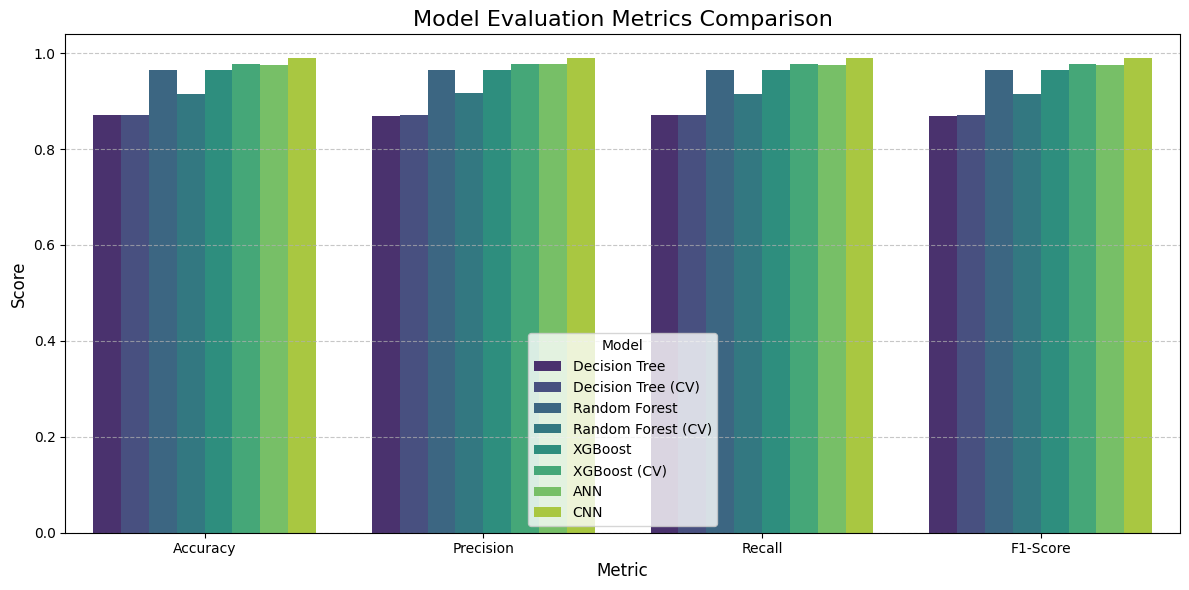

In [28]:
def visualize_metrics(metrics_df):
    """
    Visualize evaluation metrics for each model as a bar chart.
    
    Parameters:
        metrics_df (pd.DataFrame): DataFrame containing model names and their metrics.
    """
    # Melt the DataFrame for easier plotting with Seaborn
    metrics_melted = metrics_df.melt(id_vars="Model", 
                                     var_name="Metric", 
                                     value_name="Score")
    
    # Plot using Seaborn
    plt.figure(figsize=(12, 6))
    sns.barplot(data=metrics_melted, x="Metric", y="Score", hue="Model", palette="viridis")
    plt.title("Model Evaluation Metrics Comparison", fontsize=16)
    plt.ylabel("Score", fontsize=12)
    plt.xlabel("Metric", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(title="Model", fontsize=10)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

# Call the function to visualize
visualize_metrics(metrics_df)

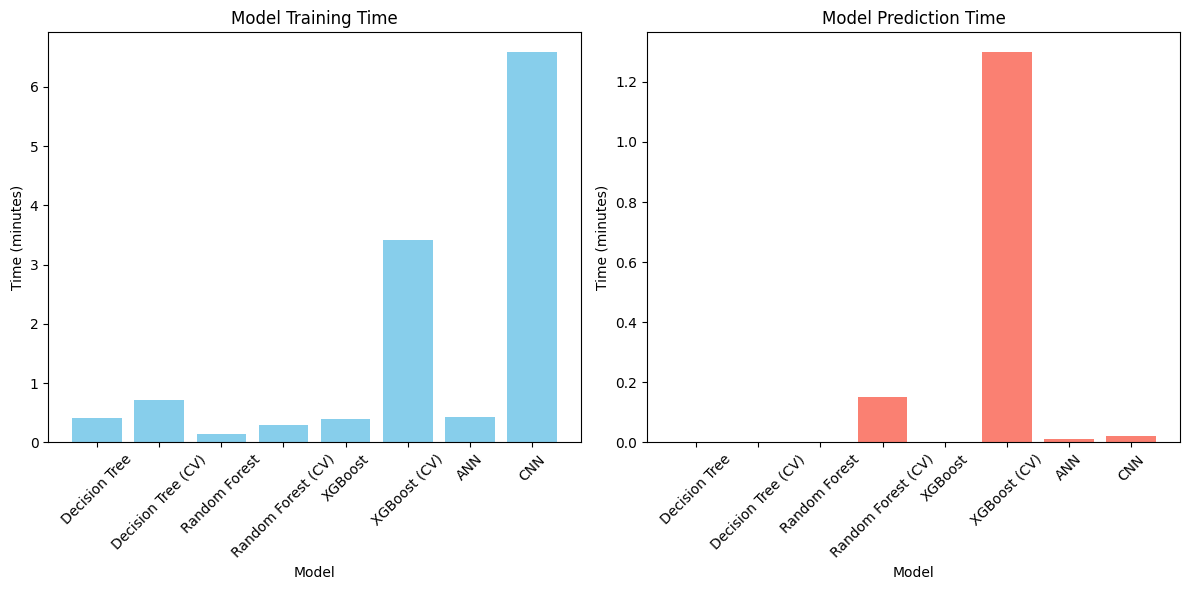

In [29]:
# Plot Training Time and Prediction Time Side by Side with Units
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=False)

# Plot for Training Time
axes[0].bar(time_df_graph["Model"], time_df_graph["Training Time"], color='skyblue')
axes[0].set_title("Model Training Time")
axes[0].set_xlabel("Model")
axes[0].set_ylabel(y_axis_labels["Training Time"])
axes[0].tick_params(axis='x', rotation=45)

# Plot for Prediction Time
axes[1].bar(time_df_graph["Model"], time_df_graph["Prediction Time"], color='salmon')
axes[1].set_title("Model Prediction Time")
axes[1].set_xlabel("Model")
axes[1].set_ylabel(y_axis_labels["Prediction Time"])
axes[1].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

# Testing Model (on Hand Written Data & Computer Font)

## Downlaod File

In [30]:
# Define Google Download String
google_download_string = 'https://drive.google.com/uc?export=download&id='

# URL of the file on Google Drive
# file_id = '10O9Y06QjOOuaq2l00NWcUpjM3gndijaw' # jhalki
# file_id = '10RtRDZ3wqNsz4Edg8wegduvAe0_PBXxY' # normal
# file_id = '10Up98WaBjvRQyTSSL90m7D6-AlXGc4Pw' # fat
# file_id = '10XEd-kcJ6YsZSybC7_ixLUuXUO399MuS' # bold_digits
# file_id = '10t2v-nccOnv7fsOwwMyEdAOaIH-U6XA6' # numbersx80
file_id = '11ADpAFrm6Vy1K8q55E00pdrPiyTLDLEM' # ALL_Images

file_url = google_download_string + file_id

# Output filename
base_name = "Images"
output_file = base_name + ".zip"

# Download the file
print("Downloading dataset...")
try:
    gdown.download(file_url, output_file, quiet=False)
    print(f"File downloaded: {output_file}")
except Exception as e:
    print(f"Failed to download the file: {e}")
    exit()

# Check if the file exists and unzip it
if os.path.exists(output_file):
    if output_file.endswith(output_file):
        print("Extracting ZIP file...")
        try:
           with zipfile.ZipFile(output_file, 'r') as zip_ref:
            zip_ref.extractall(base_name)
            print(f"Dataset extracted to '{base_name}' folder.")
        except zipfile.BadZipFile:
            print("Error: The file is not a valid ZIP archive.")
    else:
        print(f"The file {output_file} is not a ZIP file.")
else:
    print(f"The file {output_file} does not exist after download.")

Downloading...
From (original): https://drive.google.com/uc?export=download&id=11ADpAFrm6Vy1K8q55E00pdrPiyTLDLEM
From (redirected): https://drive.google.com/uc?export=download&id=11ADpAFrm6Vy1K8q55E00pdrPiyTLDLEM&confirm=t&uuid=355a67ad-e8ea-4c1e-88aa-ff35017b034e
To: d:\Fore\DLM CNN\Images.zip
100%|██████████| 12.1M/12.1M [00:01<00:00, 7.08MB/s]


File downloaded: Images.zip
Extracting ZIP file...
Dataset extracted to 'Images' folder.


## Preprocessing

In [31]:
def preprocess_image(image_path):
    # Read the image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Image file could not be read: {image_path}")
    # Resize to 28x28
    img_resized = cv2.resize(img, (28, 28))
    
    sigma_value = 0.3
    min_threshold = 175
    max_threshold = 175
    step = 10
    methods=['gaussian']
    
    # Normalize pixel values
    img_normalized = preprocess_threshold(img_resized, sigma = sigma_value, min_threshold = min_threshold, max_threshold = max_threshold, step = step, methods = methods)
    # Flatten to match model input
    return img_normalized.flatten()

# Load all images in the bold_digits folder
images = []
true_labels = []  # Store true labels

for img_file in os.listdir(base_name):
    if img_file.endswith(".png") or img_file.endswith(".jpg"):  # Process only PNG files
        img_path = os.path.join(base_name, img_file)
        images.append(preprocess_image(img_path))
        # Extract the true label from the first character of the file name
        true_labels.append(int(img_file[0]))
    else:
        print(f"Skipping non-image file: {img_file}")
        file_to_delete = os.path.join(base_name, img_file)
        try:
            os.remove(file_to_delete)
            print(f"Deleted non-image file: {file_to_delete}")
        except Exception as e:
            print(f"Failed to delete file {file_to_delete}: {e}")

images = 1 - np.array(images)

## Visualization

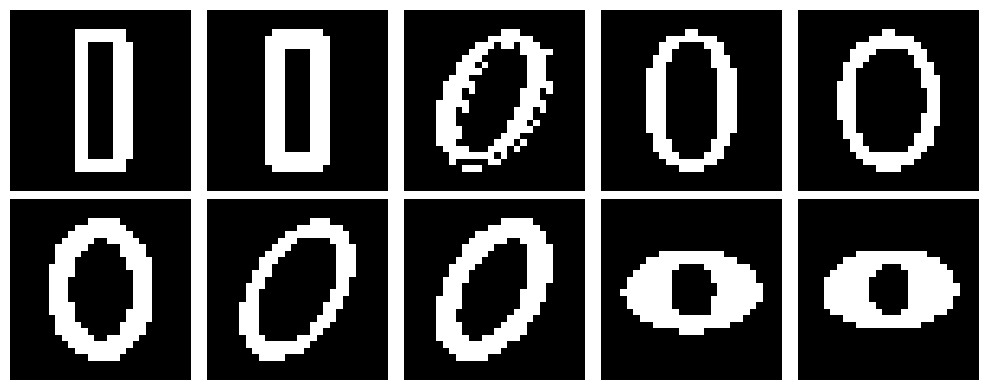

In [32]:
# Function to display normalized images
def display_normalized_images(images, rows=5, cols=5):
    """
    Display a grid of normalized images.

    Parameters:
        images (numpy.ndarray): Array of flattened normalized images.
        rows (int): Number of rows in the grid.
        cols (int): Number of columns in the grid.
    """
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    axes = axes.flatten()

    for i in range(rows * cols):
        if i < len(images):
            # Reshape flattened image back to 28x28
            img = images[i].reshape(28, 28)
            axes[i].imshow(img, cmap='gray')
            axes[i].axis('off')
        else:
            # Turn off unused subplots
            axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage (ensure `images` is defined):
display_normalized_images(images, rows=2, cols=5)

## Results

In [33]:
# Evaluate predictions against true labels and print metrics
def evaluate_and_collect_metrics(model_name, true_labels, predictions):
    acc = accuracy_score(true_labels, predictions)
    prec = precision_score(true_labels, predictions, average='weighted')
    rec = recall_score(true_labels, predictions, average='weighted')
    f1 = f1_score(true_labels, predictions, average='weighted')

    cm = confusion_matrix(true_labels, predictions)
    hit_rate = np.diag(cm).sum() / cm.sum()
    miss_rate = 1 - hit_rate

    return {
        "Model": model_name,
        "Accuracy": f"{acc * 100:.2f}%",
        "Precision": f"{prec * 100:.2f}%",
        "Recall": f"{rec * 100:.2f}%",
        "F1-Score": f"{f1 * 100:.2f}%",
    }

In [34]:
# Collect metrics for all models
results = []

# Predictions with models
models = {
    "Decision Tree": dt,
    "Decision Tree (CV)": dt_cv,
    "Random Forest": rf,
    "Random Forest (CV)": rf_cv,
    "XGBoost": xgb,
    "XGBoost (CV)": xgb_cv,
    "ANN": nn,  # Adding Neural Network model
    "CNN": cnn,  # Adding CNN model
}

for model_name, model in models.items():
    if model_name == "ANN":
        # Reshape for NN (flattened images)
        predictions = model.predict(images.reshape(images.shape[0], 28*28))
        predicted_labels = np.argmax(predictions, axis=1)
    elif model_name in ["CNN", "CNN (CV)"]:
        # Reshape images for CNN input (batch, height, width, channels)
        predictions = model.predict(images.reshape(images.shape[0], 28, 28, 1))
        predicted_labels = np.argmax(predictions, axis=1)
    else:
        # Traditional models do not require reshaping
        predicted_labels = model.predict(images)

    results.append(evaluate_and_collect_metrics(model_name, true_labels, predicted_labels))

# Create DataFrame to display results
results_df = pd.DataFrame(results)
results_df

320/320 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


,Model,Accuracy,Precision,Recall,F1-Score
0,Decision Tree,51.33%,50.83%,51.33%,49.49%
1,Decision Tree (CV),51.10%,51.37%,51.10%,49.47%
2,Random Forest,64.02%,65.61%,64.02%,59.99%
3,Random Forest (CV),64.45%,65.51%,64.45%,60.52%
4,XGBoost,65.17%,65.44%,65.17%,61.76%
5,XGBoost (CV),70.31%,71.38%,70.31%,67.00%
6,ANN,74.56%,77.93%,74.56%,72.19%
7,CNN,88.50%,88.93%,88.50%,88.11%


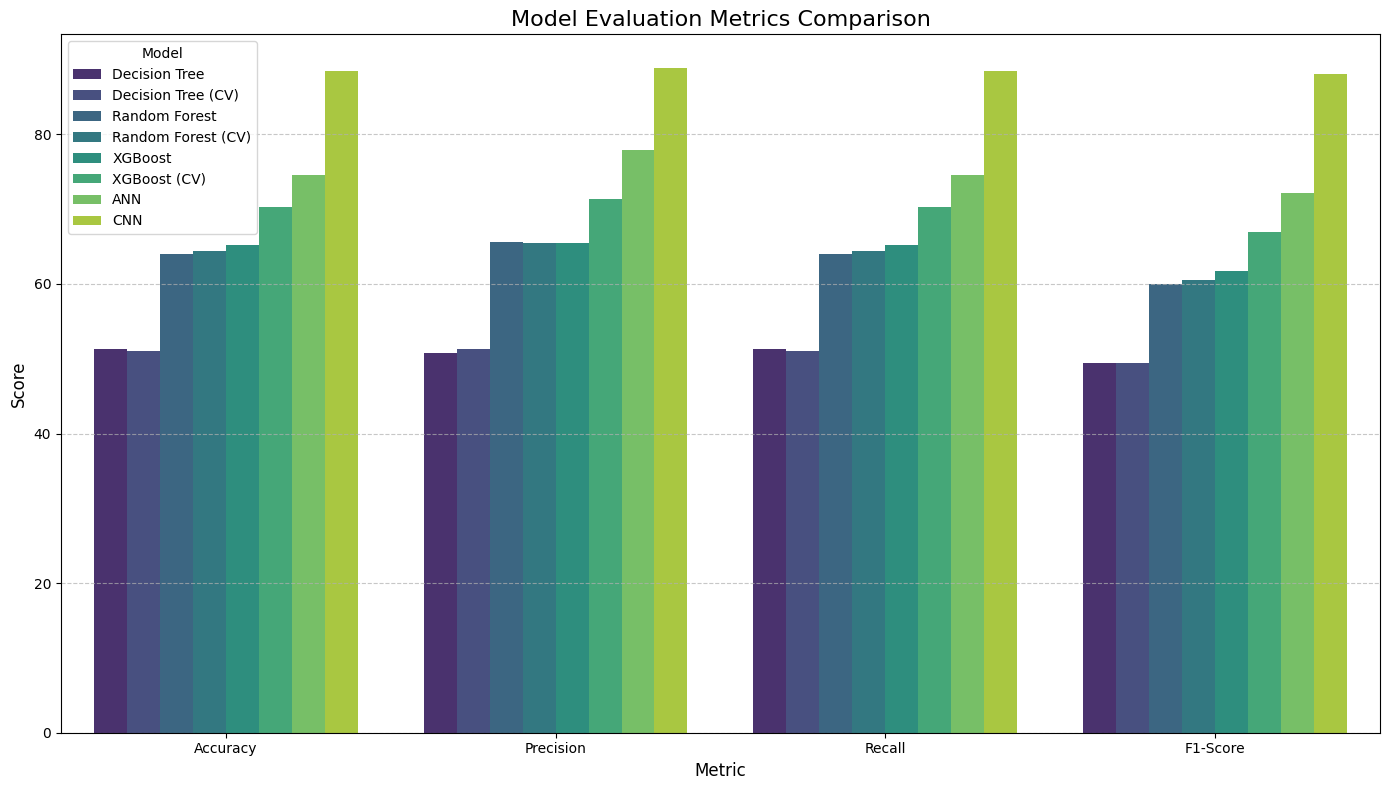

In [35]:
def visualize_metrics(metrics_df):
    """
    Visualize evaluation metrics for each model as a bar chart.
    
    Parameters:
        metrics_df (pd.DataFrame): DataFrame containing model names and their metrics.
    """
    # Convert percentage strings to numeric values for plotting
    metrics_df_numeric = metrics_df.copy()
    for column in metrics_df_numeric.columns[1:]:
        metrics_df_numeric[column] = metrics_df_numeric[column].str.rstrip('%').astype(float)

    # Melt the DataFrame for easier plotting with Seaborn
    metrics_melted = metrics_df_numeric.melt(id_vars="Model", 
                                             var_name="Metric", 
                                             value_name="Score")
    
    # Plot using Seaborn
    plt.figure(figsize=(14, 8))
    sns.barplot(data=metrics_melted, x="Metric", y="Score", hue="Model", palette="viridis")
    plt.title("Model Evaluation Metrics Comparison", fontsize=16)
    plt.ylabel("Score", fontsize=12)
    plt.xlabel("Metric", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(title="Model", fontsize=10)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

# Example usage (ensure `results_df` is defined):
visualize_metrics(results_df)

## Analysis

In [36]:
def analyze_predictions(model_name, true_labels, predictions):
    """
    Analyze predictions to identify correctly and incorrectly classified digits.

    Parameters:
        model_name (str): Name of the model.
        true_labels (array-like): Ground truth labels.
        predictions (array-like): Predicted labels by the model.
    """
    correctly_classified = []
    incorrectly_classified = []

    # Handle ANN and CNN predictions differently
    if model_name in ["ANN", "CNN"]:
        if model_name == "ANN":
            predictions = nn.predict(images.reshape(images.shape[0], 28*28))
        elif model_name == "CNN":
            predictions = cnn.predict(images.reshape(images.shape[0], 28, 28, 1))

        predictions = np.argmax(predictions, axis=1)  # Convert probabilities to class labels

    for i, (true_label, pred_label) in enumerate(zip(true_labels, predictions)):
        if true_label == pred_label:
            correctly_classified.append((i, true_label))
        else:
            incorrectly_classified.append((i, true_label, pred_label))

    print(f"\nAnalysis for {model_name}:")
    print(f"Correctly classified digits: {len(correctly_classified)}")
    print(f"Incorrectly classified digits: {len(incorrectly_classified)}")

    # Plot correctly classified digits
    print("\nDisplaying Correctly Classified Digits:")
    correct_images = [images[i] for i, _ in correctly_classified]
    display_normalized_images(correct_images, rows=4, cols=5)

    # Plot incorrectly classified digits
    print("\nDisplaying Incorrectly Classified Digits:")
    incorrect_images = [images[i] for i, _, _ in incorrectly_classified]
    display_normalized_images(incorrect_images, rows=1, cols=5)

    # Display incorrectly classified digits with their true and predicted labels
    print("\nDetails of Incorrectly Classified Digits:")
    for i, true_label, pred_label in incorrectly_classified:
        print(f"Image {i}: True Label = {true_label}, Predicted Label = {pred_label}")

    return correctly_classified, incorrectly_classified


def call_analyze_predictions(selected_model_name):
    """
    Call the analyze_predictions function for the selected model.

    Parameters:
        selected_model_name (str): Name of the selected model.
    """
    if selected_model_name in ["ANN", "CNN"]:
        if selected_model_name == "ANN":
            selected_model_predictions = nn.predict(images.reshape(images.shape[0], 28*28))
        elif selected_model_name == "CNN":        
            selected_model_predictions = cnn.predict(images.reshape(images.shape[0], 28, 28, 1))

        selected_model_predictions = np.argmax(selected_model_predictions, axis=1)
    else:
        selected_model_predictions = models[selected_model_name].predict(images)

    correct, incorrect = analyze_predictions(selected_model_name, true_labels, selected_model_predictions)
    return correct, incorrect


320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

Analysis for CNN:
Correctly classified digits: 9058
Incorrectly classified digits: 1177

Displaying Correctly Classified Digits:


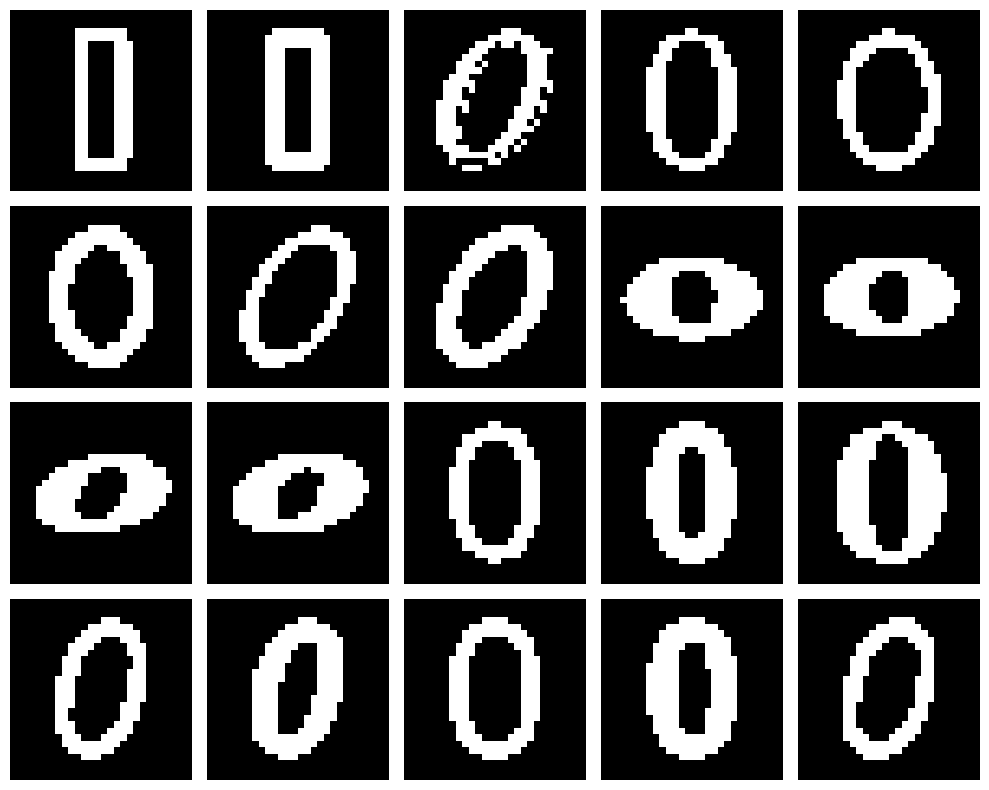


Displaying Incorrectly Classified Digits:


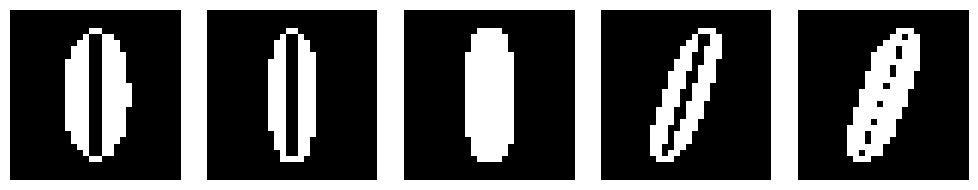


Details of Incorrectly Classified Digits:
Image 37: True Label = 0, Predicted Label = 4
Image 41: True Label = 0, Predicted Label = 1
Image 42: True Label = 0, Predicted Label = 1
Image 43: True Label = 0, Predicted Label = 8
Image 44: True Label = 0, Predicted Label = 8
Image 153: True Label = 0, Predicted Label = 9
Image 154: True Label = 0, Predicted Label = 9
Image 155: True Label = 0, Predicted Label = 9
Image 411: True Label = 0, Predicted Label = 8
Image 412: True Label = 0, Predicted Label = 8
Image 436: True Label = 0, Predicted Label = 8
Image 437: True Label = 0, Predicted Label = 8
Image 438: True Label = 0, Predicted Label = 8
Image 467: True Label = 0, Predicted Label = 1
Image 496: True Label = 0, Predicted Label = 2
Image 671: True Label = 0, Predicted Label = 9
Image 742: True Label = 0, Predicted Label = 9
Image 743: True Label = 0, Predicted Label = 1
Image 744: True Label = 0, Predicted Label = 8
Image 745: True Label = 0, Predicted Label = 8
Image 748: True Label 

In [37]:
# Example usage for any model
selected_model_name = "CNN"
call_analyze_predictions(selected_model_name)
pass